In [1]:
# Casey Reyes & Joaquin Feria

In [2]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

# Part 1: Filtering: RDDs, DataFrames, and Spark

In [3]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/11 02:22:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#q1

# TODO: modify to treat the first row as a header
# TODO: modify to infer the schema
banks_df = (spark.read.format("csv")
            .option("header", True)
            .option("inferSchema", True)
            .load("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv"))
rdd = banks_df.rdd
filtered_banks = rdd.filter(lambda x: "first" in x[0].lower())
filtered_banks.count()

# filtered_bank_names = filtered_banks.collect()
# for name in filtered_bank_names:
#     print(name[0])

525

In [5]:
#q2
from pyspark.sql.functions import expr, col, lower

col("respondent_name")
expr("respondent_name")

filtered_df = banks_df.filter(lower(expr("respondent_name")).like("%first%"))
filtered_pandas_df = filtered_df.select("respondent_name")
filtered_pandas_df.count()

525

In [6]:
#q3

banks_df.write.saveAsTable("banks", mode="overwrite")
filtered_df = spark.sql("SELECT * FROM banks WHERE LOWER(respondent_name) LIKE '%first%'")
filtered_df.count()

23/11/11 02:22:48 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/11 02:22:48 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/11 02:22:53 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/11 02:22:53 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.20.0.4
23/11/11 02:22:54 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/11 02:22:55 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
23/11/11 02:22:56 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/banks; Force to delete it.
23/11/11 02:22:56 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/banks
23/11/11 02:22:59 WARN SessionState

525

## Part 2: Hive Data Warehouse

In [7]:
loans_df = (spark.read
            .format("csv")
            .option("header", True)
            .option("inferSchema", True)
            .load("hdfs://nn:9000/hdma-wi-2021.csv"))
            # .createOrReplaceTempView("codes"))
(loans_df.write.format("csv")
            .bucketBy(8, 'county_code')
            .mode("overwrite")
            .saveAsTable('loans'))

# loans_df.printSchema
views_list = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]
for view in views_list:
    loans_df.createOrReplaceTempView(view)

23/11/11 02:23:13 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/loans was not found. Was it deleted very recently?
23/11/11 02:23:14 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/loans; Force to delete it.
23/11/11 02:23:14 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/loans
23/11/11 02:23:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/11/11 02:23:40 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider csv. Persisting data source table `spark_catalog`.`default`.`loans` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


In [8]:
#q4

# spark.sql("SHOW TABLES").show()
tables_df = spark.sql("SHOW TABLES")
table_list = tables_df.collect()
table_dict = {row['tableName']: row['isTemporary'] for row in table_list}
table_dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [9]:
#q5

bank_name = "University of Wisconsin Credit Union"
total_df = banks_df.join(
    loans_df,
    loans_df["lei"] == banks_df["lei_2020"],
    "inner"
).filter(banks_df["respondent_name"] == bank_name)
total_df.count()

19739

In [10]:
#q6

#1. The table in input[4], lei_2020.
#2. It does not involve hash aggregates.

total_df.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (7)
+- BroadcastHashJoin Inner BuildLeft (6)
   :- BroadcastExchange (3)
   :  +- Filter (2)
   :     +- Scan csv  (1)
   +- Filter (5)
      +- Scan csv  (4)


(1) Scan csv 
Output [5]: [respondent_name#17, arid_2017#18, lei_2018#19, lei_2019#20, lei_2020#21]
Batched: false
Location: InMemoryFileIndex [hdfs://nn:9000/arid2017_to_lei_xref_csv.csv]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,arid_2017:string,lei_2018:string,lei_2019:string,lei_2020:string>

(2) Filter
Input [5]: [respondent_name#17, arid_2017#18, lei_2018#19, lei_2019#20, lei_2020#21]
Condition : ((isnotnull(respondent_name#17) AND (respondent_name#17 = University of Wisconsin Credit Union)) AND isnotnull(lei_2020#21))

(3) BroadcastExchange
Input [5]: [respondent_name#17, arid_2017#18, lei_2018#19, lei_2019#20, lei_2020#21]
Arguments: HashedRelationBroadcast

## Part 3: Grouping Rows

In [11]:
#q7
from pyspark.sql.functions import avg, count

counties_df = (spark.read
            .format("csv")
            .option("header", True)
            .option("inferSchema", True)
            .load("hdfs://nn:9000/counties.csv"))

joined_df = banks_df.join(
    loans_df,
    loans_df["lei"] == banks_df["lei_2020"],
    "inner"
).filter(banks_df["respondent_name"].like("%Wells Fargo%"))
result = (joined_df
 .join(counties_df, on=loans_df["county_code"] == counties_df["STATE"] * 1000 + counties_df["COUNTY"])
 .groupBy("NAME")
 .agg(avg("interest_rate").alias("avg_interest_rate"), count("*").alias("application_count"))
 .orderBy("application_count", ascending=False)
 .select("NAME", "avg_interest_rate")
 .limit(10))
 # .show())

result_list = result.rdd.map(lambda row: row.asDict()).collect()
result_dict = {entry["NAME"]: entry["avg_interest_rate"] for entry in result_list}
result_dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

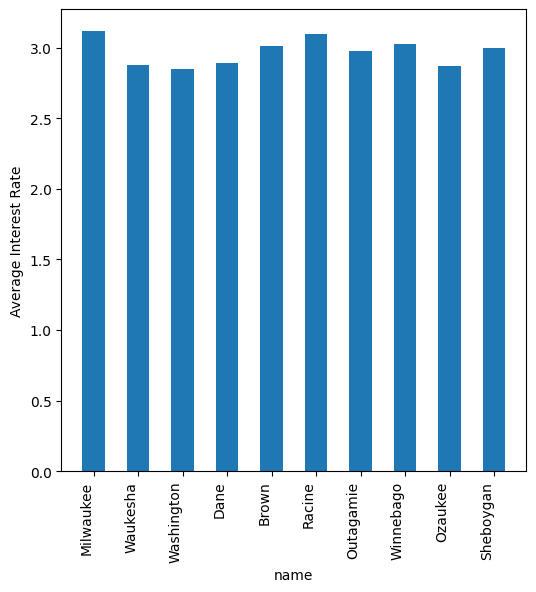

In [12]:
import matplotlib.pyplot as plt

counties = list(result_dict.keys())
avg_interest_rates = list(result_dict.values())

plt.figure(figsize=(6, 6))
plt.bar(counties, avg_interest_rates, width=0.5)
plt.xlabel('name')
plt.ylabel('Average Interest Rate')
plt.xticks(rotation=90, ha='right')

plt.show()

In [13]:
#q8

(loans_df.groupBy("county_code").agg({"interest_rate": "mean"}).explain())
(loans_df.groupBy("lei").agg({"interest_rate": "mean"}).explain())

# We would require network I/O between the partial_mean and mean if the data that is being used to calculate mean is in different partitions.

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#103], functions=[avg(cast(interest_rate#122 as double))])
   +- Exchange hashpartitioning(county_code#103, 200), ENSURE_REQUIREMENTS, [plan_id=652]
      +- HashAggregate(keys=[county_code#103], functions=[partial_avg(cast(interest_rate#122 as double))])
         +- FileScan csv [county_code#103,interest_rate#122] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/hdma-wi-2021.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,interest_rate:string>


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#100], functions=[avg(cast(interest_rate#122 as double))])
   +- Exchange hashpartitioning(lei#100, 200), ENSURE_REQUIREMENTS, [plan_id=665]
      +- HashAggregate(keys=[lei#100], functions=[partial_avg(cast(interest_rate#122 as double))])
         +- FileScan csv [lei#100,interest_rate#122

## Part 4: Machine Learning

In [14]:
import pandas as pd
import numpy as np
from pyspark.sql import functions as F

action_df = (spark.read
            .format("csv")
            .option("header", True)
            .option("inferSchema", True)
            .load("hdfs://nn:9000/action_taken.csv"))

selected_columns = ["loan_amount", "income", "interest_rate", "action_taken"]
label_column = "approval"

df = loans_df.select(selected_columns).toPandas()
df = df.applymap(pd.to_numeric, errors='coerce')
df.fillna(0.0, inplace=True)

df["loan_amount"] = df["loan_amount"].astype(float)
df["interest_rate"] = df["interest_rate"].astype(float)
df["income"] = df["income"].astype(float)
df["approval"] = df["action_taken"].astype(float)

df = spark.createDataFrame(df)

df = df.withColumn(
    "approval",
    F.when(df["action_taken"] == 1, 1.0).otherwise(0.0)
)
df = df.drop("action_taken")
df.show()

/tmp/ipykernel_136/4041393036.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(pd.to_numeric, errors='coerce')
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
23/11/11 02:25:03 WARN TaskSetManager: Stage 27 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.


+-----------+------+-------------+--------+
|loan_amount|income|interest_rate|approval|
+-----------+------+-------------+--------+
|   305000.0| 108.0|        3.875|     0.0|
|    65000.0| 103.0|          0.0|     0.0|
|    75000.0| 146.0|         3.25|     0.0|
|   155000.0|  70.0|          4.0|     1.0|
|   305000.0|  71.0|         3.25|     1.0|
|   175000.0| 117.0|        3.375|     1.0|
|   575000.0| 180.0|          4.5|     1.0|
|   105000.0| 180.0|        5.375|     1.0|
|    85000.0| 136.0|        3.375|     1.0|
|   405000.0|   0.0|          0.0|     1.0|
|   255000.0| 210.0|          0.0|     1.0|
|   275000.0| 185.0|          0.0|     1.0|
|   435000.0| 190.0|          0.0|     1.0|
|   205000.0|   0.0|          0.0|     1.0|
|   295000.0| 101.0|        2.999|     1.0|
|   195000.0|  43.0|         2.75|     1.0|
|   305000.0|   0.0|         2.25|     1.0|
|   265000.0|  93.0|         2.75|     1.0|
|   515000.0| 206.0|        2.875|     1.0|
|   475000.0|   0.0|        1.99

In [15]:
train, test = df.randomSplit([0.8, 0.2], seed=41)
train.cache()

DataFrame[loan_amount: double, income: double, interest_rate: double, approval: double]

In [16]:
#q9
train.filter(df["approval"] == 1.0).count()

23/11/11 02:25:07 WARN TaskSetManager: Stage 28 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:25:19 WARN TaskSetManager: Stage 29 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.


242976

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="approval", maxDepth=5)

model = dt.fit(va.transform(train))

from pyspark.ml.pipeline import Pipeline, PipelineModel

23/11/11 02:25:23 WARN TaskSetManager: Stage 32 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:25:27 WARN TaskSetManager: Stage 35 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:25:29 WARN TaskSetManager: Stage 36 contains a task of very large size (8987 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:25:36 WARN TaskSetManager: Stage 37 contains a task of very large size (8987 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:25:41 WARN TaskSetManager: Stage 39 contains a task of very large size (8987 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:25:47 WARN TaskSetManager: Stage 41 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:25:51 WARN TaskSetManager: Stage 43 contains a task of very large size (8987 KiB). The maximum recommended task size is 1000 KiB.
23/11/

In [18]:
#q10

pipe = Pipeline(stages=[va,dt])
model = pipe.fit(train)
df = model.transform(test).toPandas()

correct = 0
total = 0
for i in range(len(df["approval"])):
    if (df["approval"][i] == df["prediction"][i]):
        correct += 1
    total += 1

correct/total

23/11/11 02:25:59 WARN TaskSetManager: Stage 49 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:26:01 WARN TaskSetManager: Stage 52 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:26:01 WARN TaskSetManager: Stage 53 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:26:03 WARN TaskSetManager: Stage 54 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:26:06 WARN TaskSetManager: Stage 56 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:26:10 WARN TaskSetManager: Stage 58 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/11 02:26:12 WARN TaskSetManager: Stage 60 contains a task of very large size (8951 KiB). The maximum recommended task size is 1000 KiB.
23/11/

0.8926433610004673